In [ ]:
!pip install -U torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install wheel==0.34.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [ ]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
!pip uninstall -y Pillow
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip -d dataset
!ls dataset
!rm -rf test
!rm -rf train
!nvidia-smi
import torch
torch.cuda.is_available()

characters_illustration.png  sample_submission.csv  testset  train
Tue Apr 18 17:52:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                     

True

In [ ]:
import pickle
import numpy as np
import pandas as pd
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import datasets, models, transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
import torch.nn as nn

from matplotlib import colors, pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

###1. Подготовка данных

In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры.
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        '''Возвращает количество файлов.'''
        return self.len_
      
    def load_sample(self, file):
        '''Загружает одну картинку.'''
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        '''Преобразует тензоры в pytorch, аугментирует и нормализует выход.'''
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        aug = self._augmentation()
        x = self.load_sample(self.files[index])
        if self.mode == 'train':
            x = aug(x)
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _augmentation(self):
        '''Делает аугментацию данных.'''
        augmentations = transforms.RandomChoice([
            transforms.Compose([
                transforms.Resize(size=224),
                transforms.CenterCrop(size=224),
                transforms.RandomCrop(size=224)
            ]),
            transforms.RandomRotation(degrees=(-25, 25)),
            transforms.RandomHorizontalFlip(p=1),
        ])
        return augmentations

    def _prepare_sample(self, image):
        '''Обрезает картинку.'''
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Восстанавливает картинки из тензоров."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
TRAIN_DIR = Path('/content/dataset/train')
TEST_DIR = Path('/content/dataset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

###2. Анализ данных

In [ ]:
# Разделим данные на train и test.
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
# Создадим тренировочный и тестовый датасеты.
val_dataset = SimpsonsDataset(val_files, mode='val') 
train_dataset = SimpsonsDataset(train_files, mode='train')

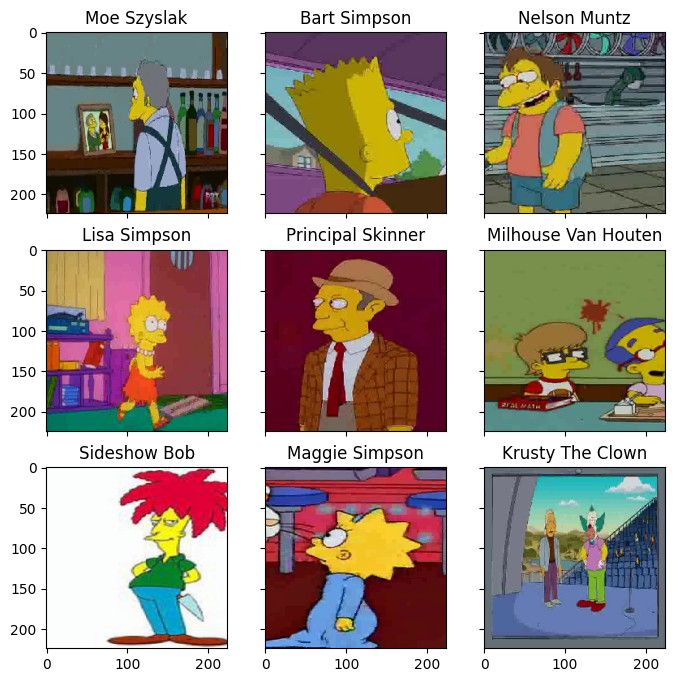

In [ ]:
# Посмотрим на изображения в нашем датасете.
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8),\
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, len(val_dataset)))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0]\
                .split('_')))
    imshow(im_val.data.cpu(),\
          title=img_label,plt_ax=fig_x)

In [ ]:
# Создадим датафрейм с количеством картинок для каждого класса.
df = pd.DataFrame(train_val_labels, columns=['name_of_character'])
df['number_of_pictures'] = 1
df = df.groupby('name_of_character').count().sort_values('number_of_pictures')

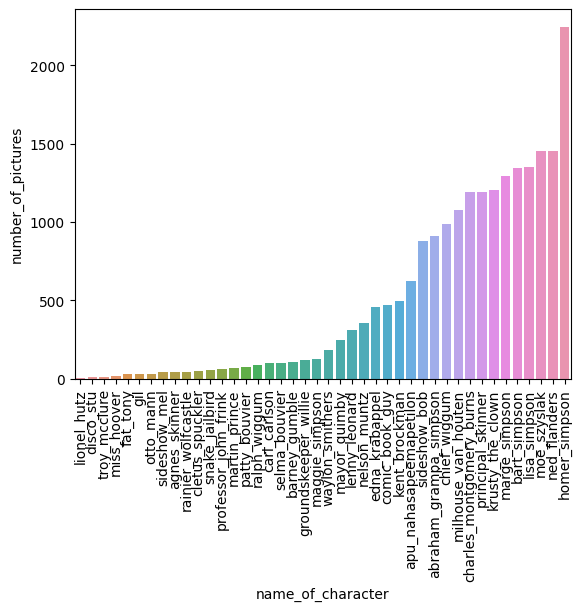

In [ ]:
# Посмотрим на распределение классов.
sns.barplot(x=df.index, y='number_of_pictures', data=df)
plt.xticks(rotation=90)
plt.show()

Видно, что датасет несбалансирован. Сбалансируем классы.

In [ ]:
class DatasetBalancing:
    '''Балансирует распределение классов в датасете.'''

    def __init__(self, train_dataset) -> None:
        self.train_dataset = train_dataset
        self.encoder = pickle.load(open("label_encoder.pkl", 'rb'))
        self.name_weights = None
        self.sample_weights = []
    
    def get_number_of_object_df(self) -> pd.DataFrame:
        '''Создает датасет с рапределением классов.'''
        df = pd.DataFrame(train_val_labels, columns=['name_of_character'])
        df['number_of_pictures'] = 1
        df = df.groupby('name_of_character').count()
        df.reset_index(inplace=True)
        return df

    def get_weighted_dict(self) -> None:
        '''Создает словарь с весами классов (чем многочисленней класс, 
        тем меньше его вес).'''
        df = self.get_number_of_object_df()
        df['number_of_pictures'] = df['number_of_pictures'].astype(float)
        df['number_of_pictures'] **= -1
        self.name_weights = dict(zip(df['name_of_character'],\
                                     df['number_of_pictures']))

    def get_list_of_item_weights(self) -> None:
        '''Создает список из весов для каждого элемента 
        тренировочной выборки.'''
        self.get_weighted_dict()

        for _, label in self.train_dataset:
            name = self.encoder.inverse_transform([label])[0]
            element_weight = self.name_weights[name]
            self.sample_weights.append(element_weight)

    def get_train_sampler(self) -> WeightedRandomSampler:
        '''Создает объект класса WeightedRandomSampler.'''
        self.get_list_of_item_weights()
        return WeightedRandomSampler(self.sample_weights,\
                                     len(self.sample_weights))

In [ ]:
dataset_balancing = DatasetBalancing(train_dataset)
train_sampler = dataset_balancing.get_train_sampler()

### 3.Построение нейросети своей нейросети


Построим простую сверточную нейросеть и попробуем обучить ее на наших данных.

In [ ]:
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    '''Обучает модель на одной эпохе.'''
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    scheduler.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    '''Считает и возвращает качество модели на одной эпохе.'''
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_datset, val_dataset, model, epochs, batch_size,\
          train_sampler=None, show_val_acc=False):
    '''Проводит полное обучение модели и возвращает качество на тренировочной и
    тестовой выборках (если параметр show_val_acc == True).'''
    train_loader = DataLoader(train_dataset, sampler=train_sampler,\
                              batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    if show_val_acc:    
        log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
        val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    else:
        log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
        train_acc {t_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        criterion = torch.nn.CrossEntropyLoss()
        opt = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-3)
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion,\
                                              opt, scheduler)
            print("loss", train_loss)
            
            if show_val_acc:
                val_loss, val_acc = eval_epoch(model, val_loader, criterion)
                history.append((train_loss, train_acc, val_loss, val_acc))
            else:
                history.append((train_loss, train_acc))
            
            pbar_outer.update(1)
            if show_val_acc:
                tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                              v_loss=val_loss, t_acc=train_acc,\
                                               v_acc=val_acc))
            else:
                tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                          t_acc=train_acc))
            
    return history

In [ ]:
def predict(model, test_loader):
    '''Возвращает предсказания модели на тестовой выборке.'''
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Возвращает предсказание для одной картинки."""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
def print_f1_score(model, val_dataset) -> None:
    '''Пишет результаты модели по метрике f1-score.'''
    idxs = list(map(int, np.random.uniform(0, len(val_dataset), 20)))
    imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

    probs_ims = predict(model, imgs)

    y_pred = np.argmax(probs_ims,-1)

    actual_labels = [val_dataset[id][1] for id in idxs]
    actual_labels = [val_dataset.label_encoder.inverse_transform([id])[0]\
                 for id in actual_labels]
    preds_class = [label_encoder.classes_[i] for i in y_pred]

    f1 = f1_score(actual_labels, preds_class, average='weighted')

    print(f'f1-score: {f1}')

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify: {}".format(n_classes))
print(simple_cnn)

we will classify: 42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

In [ ]:
def draw_accuracy(history, show_val_acc=False) -> None:
    '''Рисует кривую обучения.'''
    if show_val_acc:
        loss, acc, val_loss, val_acc = zip(*history)
    else:
        loss, acc = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    if show_val_acc:
        plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

Запустим обучение сети.

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn,\
                train_sampler=train_sampler, epochs=10, batch_size=256,\
                show_val_acc=True)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 3.1292486384428417


epoch:  10%|█         | 1/10 [01:35<14:17, 95.26s/it]


Epoch 001 train_loss: 3.1292         val_loss 3.0802 train_acc 0.1826 val_acc 0.1763
loss 2.1328800683477454


epoch:  20%|██        | 2/10 [03:00<11:54, 89.28s/it]


Epoch 002 train_loss: 2.1329         val_loss 2.3170 train_acc 0.4355 val_acc 0.3810
loss 1.4900722768976624


epoch:  30%|███       | 3/10 [04:25<10:11, 87.36s/it]


Epoch 003 train_loss: 1.4901         val_loss 2.1278 train_acc 0.6111 val_acc 0.4406
loss 1.1615073605247102


epoch:  40%|████      | 4/10 [05:50<08:38, 86.48s/it]


Epoch 004 train_loss: 1.1615         val_loss 1.7839 train_acc 0.6991 val_acc 0.5367
loss 0.9184933641251656


epoch:  50%|█████     | 5/10 [07:15<07:09, 85.95s/it]


Epoch 005 train_loss: 0.9185         val_loss 1.6266 train_acc 0.7569 val_acc 0.5816
loss 0.789219234682844


epoch:  60%|██████    | 6/10 [08:40<05:42, 85.51s/it]


Epoch 006 train_loss: 0.7892         val_loss 1.5011 train_acc 0.7934 val_acc 0.6095
loss 0.6647668016515755


epoch:  70%|███████   | 7/10 [10:06<04:16, 85.61s/it]


Epoch 007 train_loss: 0.6648         val_loss 1.4124 train_acc 0.8255 val_acc 0.6427
loss 0.5760080517686182


epoch:  80%|████████  | 8/10 [11:31<02:51, 85.70s/it]


Epoch 008 train_loss: 0.5760         val_loss 1.2826 train_acc 0.8498 val_acc 0.6679
loss 0.5195677525276241


epoch:  90%|█████████ | 9/10 [12:56<01:25, 85.27s/it]


Epoch 009 train_loss: 0.5196         val_loss 1.2668 train_acc 0.8653 val_acc 0.6792
loss 0.5012531573472186


epoch: 100%|██████████| 10/10 [14:20<00:00, 86.06s/it]


Epoch 010 train_loss: 0.5013         val_loss 1.2523 train_acc 0.8730 val_acc 0.6796


Посмотрим на кривые обучения.

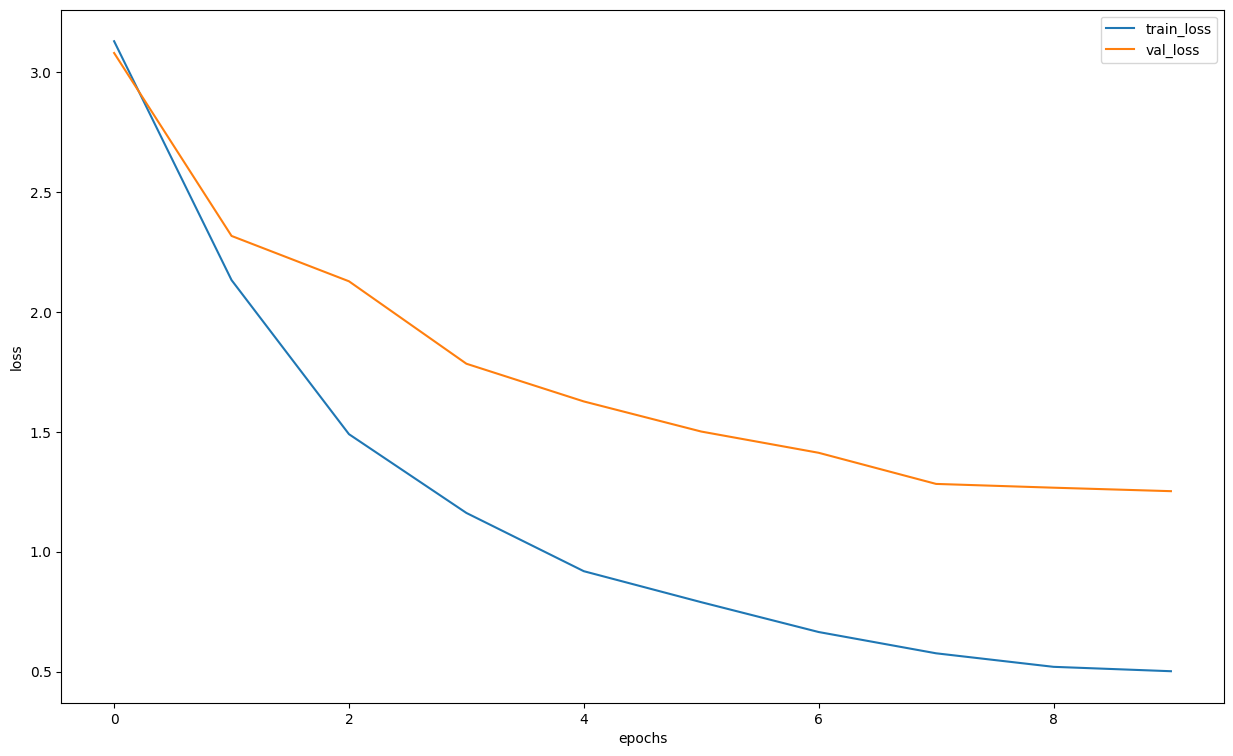

In [ ]:
draw_accuracy(history, show_val_acc=True)

Посмотрим на f1-score.

In [ ]:
print_f1_score(simple_cnn, val_dataset)

f1-score: 0.7283333333333333


## 4.Transfer Learning

Загрузим предобученные модели и сделаем файнтюнинг.

In [ ]:
def freeze_model_layers(model, layers_to_unfreeze) -> None:
    '''Оставляет обучаемыми только последние layers_to_unfreeze слоев модели.'''
    for param in model.features[:-layers_to_unfreeze].parameters():
        param.requires_grad = False

In [ ]:
def model_preparation(model, classifier_in_features,\
                      layers_to_unfreeze) -> None:
    '''Меняет классификатор модели и замораживает часть ее слоев.'''
    model.classifier = nn.Linear(in_features=classifier_in_features,\
                                 out_features=n_classes)
    freeze_model_layers(model, 5)
    model = model.cuda()

In [ ]:
model_vgg = models.vgg16(pretrained=True)
model_vgg.classifier

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 178MB/s]


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [ ]:
model_preparation(model_vgg, 25088, 5)

In [ ]:
history = train(train_dataset, val_dataset, model=model_vgg,\
                train_sampler=train_sampler, epochs=13, batch_size=256,\
                show_val_acc=True)

epoch:   0%|          | 0/13 [00:00<?, ?it/s]

loss 1.6330382321486694


epoch:   8%|▊         | 1/13 [03:12<38:30, 192.56s/it]


Epoch 001 train_loss: 1.6330         val_loss 1.3806 train_acc 0.5815 val_acc 0.6504
loss 0.48825013274576673


epoch:  15%|█▌        | 2/13 [06:23<35:05, 191.40s/it]


Epoch 002 train_loss: 0.4883         val_loss 0.7887 train_acc 0.8709 val_acc 0.7929
loss 0.3140968576522608


epoch:  23%|██▎       | 3/13 [09:33<31:50, 191.02s/it]


Epoch 003 train_loss: 0.3141         val_loss 0.7238 train_acc 0.9190 val_acc 0.8208
loss 0.21934464699721304


epoch:  31%|███       | 4/13 [12:43<28:36, 190.71s/it]


Epoch 004 train_loss: 0.2193         val_loss 0.6494 train_acc 0.9420 val_acc 0.8353
loss 0.1889716638289513


epoch:  38%|███▊      | 5/13 [15:53<25:23, 190.40s/it]


Epoch 005 train_loss: 0.1890         val_loss 0.6317 train_acc 0.9508 val_acc 0.8580
loss 0.16937962633106343


epoch:  46%|████▌     | 6/13 [19:05<22:15, 190.75s/it]


Epoch 006 train_loss: 0.1694         val_loss 0.5741 train_acc 0.9551 val_acc 0.8613
loss 0.1436719860029916


epoch:  54%|█████▍    | 7/13 [22:17<19:08, 191.40s/it]


Epoch 007 train_loss: 0.1437         val_loss 0.5540 train_acc 0.9620 val_acc 0.8716
loss 0.09167171291343967


epoch:  62%|██████▏   | 8/13 [25:30<15:59, 191.88s/it]


Epoch 008 train_loss: 0.0917         val_loss 0.4597 train_acc 0.9753 val_acc 0.8940
loss 0.06825956441113216


epoch:  69%|██████▉   | 9/13 [28:42<12:47, 191.94s/it]


Epoch 009 train_loss: 0.0683         val_loss 0.4455 train_acc 0.9820 val_acc 0.8966
loss 0.059359560407986706


epoch:  77%|███████▋  | 10/13 [31:55<09:36, 192.07s/it]


Epoch 010 train_loss: 0.0594         val_loss 0.4400 train_acc 0.9850 val_acc 0.8999
loss 0.063663012258596


epoch:  85%|████████▍ | 11/13 [35:06<06:23, 191.75s/it]


Epoch 011 train_loss: 0.0637         val_loss 0.4215 train_acc 0.9857 val_acc 0.9047
loss 0.052207083673925264


epoch:  92%|█████████▏| 12/13 [38:17<03:11, 191.71s/it]


Epoch 012 train_loss: 0.0522         val_loss 0.4311 train_acc 0.9873 val_acc 0.9026
loss 0.046794571123053345


epoch: 100%|██████████| 13/13 [41:27<00:00, 191.38s/it]


Epoch 013 train_loss: 0.0468         val_loss 0.4290 train_acc 0.9879 val_acc 0.9050


Посмотрим на кривые обучения.

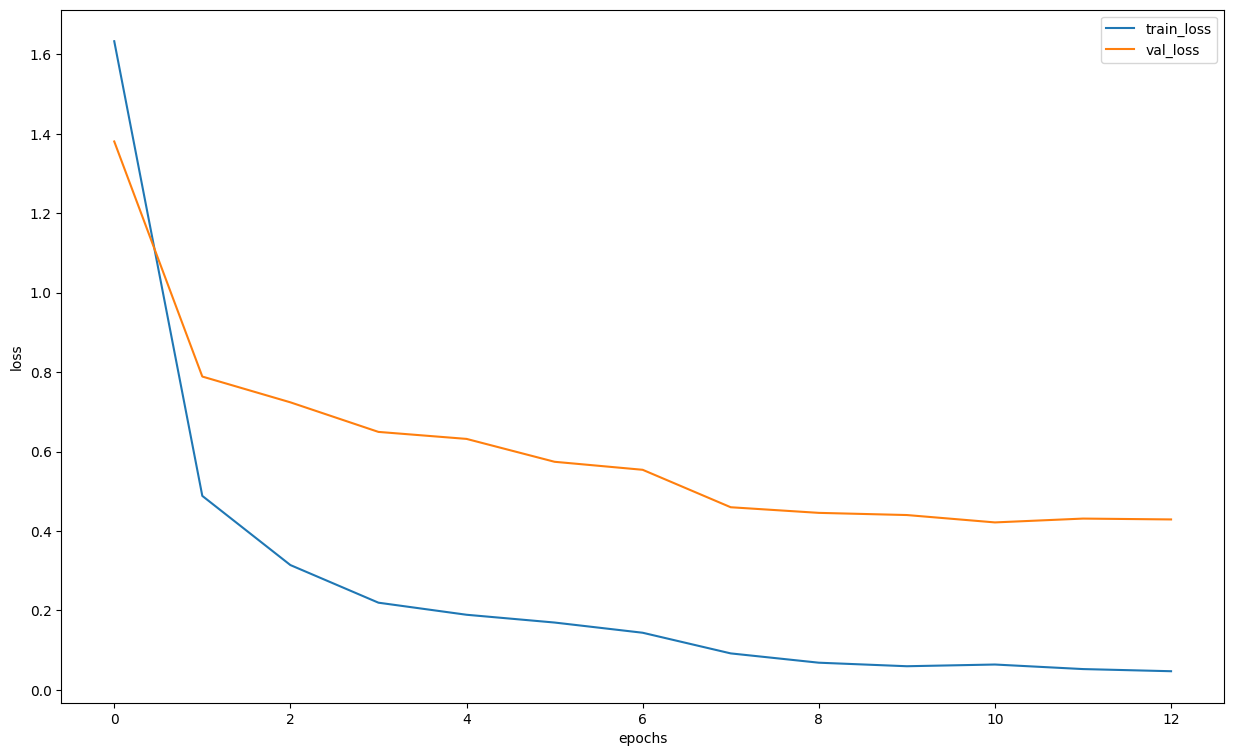

In [ ]:
draw_accuracy(history, show_val_acc=True)

In [ ]:
print_f1_score(model_vgg, val_dataset)

f1-score: 0.8619047619047618


Теперь все то же самое, но для efficient_net.

In [ ]:
model_eff = models.efficientnet_b0(pretrained=True)
model_eff.classifier

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 89.0MB/s]


Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [ ]:
model_preparation(model_eff, 1280, 5)

In [ ]:
history = train(train_dataset, val_dataset, model=model_eff,\
                train_sampler=train_sampler, epochs=13, batch_size=256,\
                show_val_acc=True)

epoch:   0%|          | 0/13 [00:00<?, ?it/s]

loss 0.8654323806446961


epoch:   8%|▊         | 1/13 [02:14<26:56, 134.68s/it]


Epoch 001 train_loss: 0.8654         val_loss 0.2254 train_acc 0.8244 val_acc 0.9400
loss 0.1765322420007864


epoch:  15%|█▌        | 2/13 [04:20<23:44, 129.51s/it]


Epoch 002 train_loss: 0.1765         val_loss 0.2770 train_acc 0.9503 val_acc 0.9234
loss 0.11215831799995854


epoch:  23%|██▎       | 3/13 [06:24<21:11, 127.13s/it]


Epoch 003 train_loss: 0.1122         val_loss 0.1985 train_acc 0.9719 val_acc 0.9476
loss 0.06966437033455124


epoch:  31%|███       | 4/13 [08:30<18:57, 126.40s/it]


Epoch 004 train_loss: 0.0697         val_loss 0.1640 train_acc 0.9817 val_acc 0.9562
loss 0.06086421391909324


epoch:  38%|███▊      | 5/13 [10:35<16:46, 125.85s/it]


Epoch 005 train_loss: 0.0609         val_loss 0.1799 train_acc 0.9845 val_acc 0.9511
loss 0.06160326575937146


epoch:  46%|████▌     | 6/13 [12:39<14:37, 125.30s/it]


Epoch 006 train_loss: 0.0616         val_loss 0.1696 train_acc 0.9837 val_acc 0.9585
loss 0.06251377642488805


epoch:  54%|█████▍    | 7/13 [14:43<12:28, 124.83s/it]


Epoch 007 train_loss: 0.0625         val_loss 0.2084 train_acc 0.9826 val_acc 0.9444
loss 0.03623101599100405


epoch:  62%|██████▏   | 8/13 [16:46<10:22, 124.45s/it]


Epoch 008 train_loss: 0.0362         val_loss 0.1136 train_acc 0.9898 val_acc 0.9729
loss 0.01506647873244868


epoch:  69%|██████▉   | 9/13 [18:52<08:19, 124.97s/it]


Epoch 009 train_loss: 0.0151         val_loss 0.1109 train_acc 0.9964 val_acc 0.9738
loss 0.013061705930689444


epoch:  77%|███████▋  | 10/13 [20:58<06:15, 125.11s/it]


Epoch 010 train_loss: 0.0131         val_loss 0.1087 train_acc 0.9972 val_acc 0.9752
loss 0.00935242841489121


epoch:  85%|████████▍ | 11/13 [23:04<04:10, 125.48s/it]


Epoch 011 train_loss: 0.0094         val_loss 0.1061 train_acc 0.9976 val_acc 0.9746
loss 0.0078017274234545644


epoch:  92%|█████████▏| 12/13 [25:08<02:05, 125.04s/it]


Epoch 012 train_loss: 0.0078         val_loss 0.1034 train_acc 0.9977 val_acc 0.9765
loss 0.008603502218621327


epoch: 100%|██████████| 13/13 [27:13<00:00, 125.65s/it]


Epoch 013 train_loss: 0.0086         val_loss 0.1017 train_acc 0.9982 val_acc 0.9765


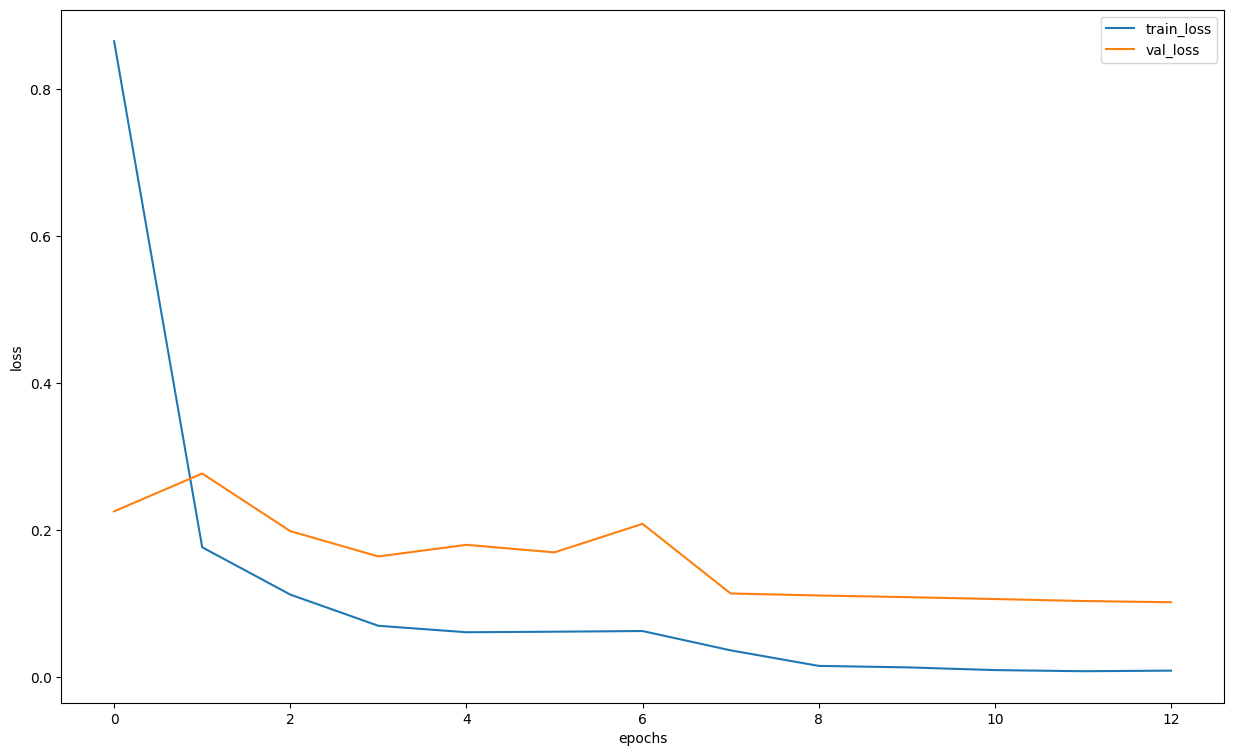

In [ ]:
draw_accuracy(history, show_val_acc=True)

In [ ]:
print_f1_score(model_eff, val_dataset)

f1-score: 0.95


Самое хорошее качество показала efiicient_net. Обучим ее на всей выборке для достижения наилучшего результата.

In [ ]:
# Проделаем все то же самое, что было раньше, заменив соотношение 
# train/test = 0.99 / 0.01
train_files, val_files = train_test_split(train_val_files, test_size=0.01,\
                                          stratify=train_val_labels)

val_dataset = SimpsonsDataset(val_files, mode='val') 
train_dataset = SimpsonsDataset(train_files, mode='train')

dataset_balancing_all_data = DatasetBalancing(train_dataset)
train_sampler_all_data = dataset_balancing_all_data.get_train_sampler()

model_eff_all_data = models.efficientnet_b0(pretrained=True)
model_preparation(model_eff_all_data, 1280, 5)

history = train(train_dataset, val_dataset, model=model_eff_all_data,\
                train_sampler=train_sampler_all_data,\
                epochs=17, batch_size=256, show_val_acc=False)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
epoch:   6%|▌         | 1/17 [02:16<36:24, 136.53s/it]

loss 0.691675269394985

Epoch 001 train_loss: 0.6917         train_acc 0.8558


epoch:  12%|█▏        | 2/17 [04:32<34:07, 136.47s/it]

loss 0.09112602992655888

Epoch 002 train_loss: 0.0911         train_acc 0.9761


epoch:  18%|█▊        | 3/17 [06:48<31:45, 136.14s/it]

loss 0.06609145720989837

Epoch 003 train_loss: 0.0661         train_acc 0.9828


epoch:  24%|██▎       | 4/17 [09:04<29:28, 136.01s/it]

loss 0.05385340255609335

Epoch 004 train_loss: 0.0539         train_acc 0.9855


epoch:  29%|██▉       | 5/17 [11:19<27:07, 135.59s/it]

loss 0.038979275223454304

Epoch 005 train_loss: 0.0390         train_acc 0.9891


epoch:  35%|███▌      | 6/17 [13:34<24:50, 135.46s/it]

loss 0.036588072467956485

Epoch 006 train_loss: 0.0366         train_acc 0.9909


epoch:  41%|████      | 7/17 [15:49<22:33, 135.35s/it]

loss 0.031488530218086376

Epoch 007 train_loss: 0.0315         train_acc 0.9918


epoch:  47%|████▋     | 8/17 [18:05<20:18, 135.34s/it]

loss 0.023452977295728563

Epoch 008 train_loss: 0.0235         train_acc 0.9944


epoch:  53%|█████▎    | 9/17 [20:21<18:05, 135.65s/it]

loss 0.012529924874104217

Epoch 009 train_loss: 0.0125         train_acc 0.9969


epoch:  59%|█████▉    | 10/17 [22:37<15:51, 135.91s/it]

loss 0.016590163240758675

Epoch 010 train_loss: 0.0166         train_acc 0.9963


epoch:  65%|██████▍   | 11/17 [24:55<13:39, 136.58s/it]

loss 0.009303034951905252

Epoch 011 train_loss: 0.0093         train_acc 0.9974


epoch:  71%|███████   | 12/17 [27:14<11:26, 137.22s/it]

loss 0.010489811217785817

Epoch 012 train_loss: 0.0105         train_acc 0.9972


epoch:  76%|███████▋  | 13/17 [29:31<09:08, 137.25s/it]

loss 0.009010162739892028

Epoch 013 train_loss: 0.0090         train_acc 0.9981


epoch:  82%|████████▏ | 14/17 [31:48<06:51, 137.09s/it]

loss 0.007353005085881282

Epoch 014 train_loss: 0.0074         train_acc 0.9983


epoch:  88%|████████▊ | 15/17 [34:06<04:34, 137.26s/it]

loss 0.0073466080337434

Epoch 015 train_loss: 0.0073         train_acc 0.9981


epoch:  94%|█████████▍| 16/17 [36:25<02:17, 137.87s/it]

loss 0.0070556293993258735

Epoch 016 train_loss: 0.0071         train_acc 0.9981


epoch: 100%|██████████| 17/17 [38:43<00:00, 136.70s/it]

loss 0.006883396549338293

Epoch 017 train_loss: 0.0069         train_acc 0.9979


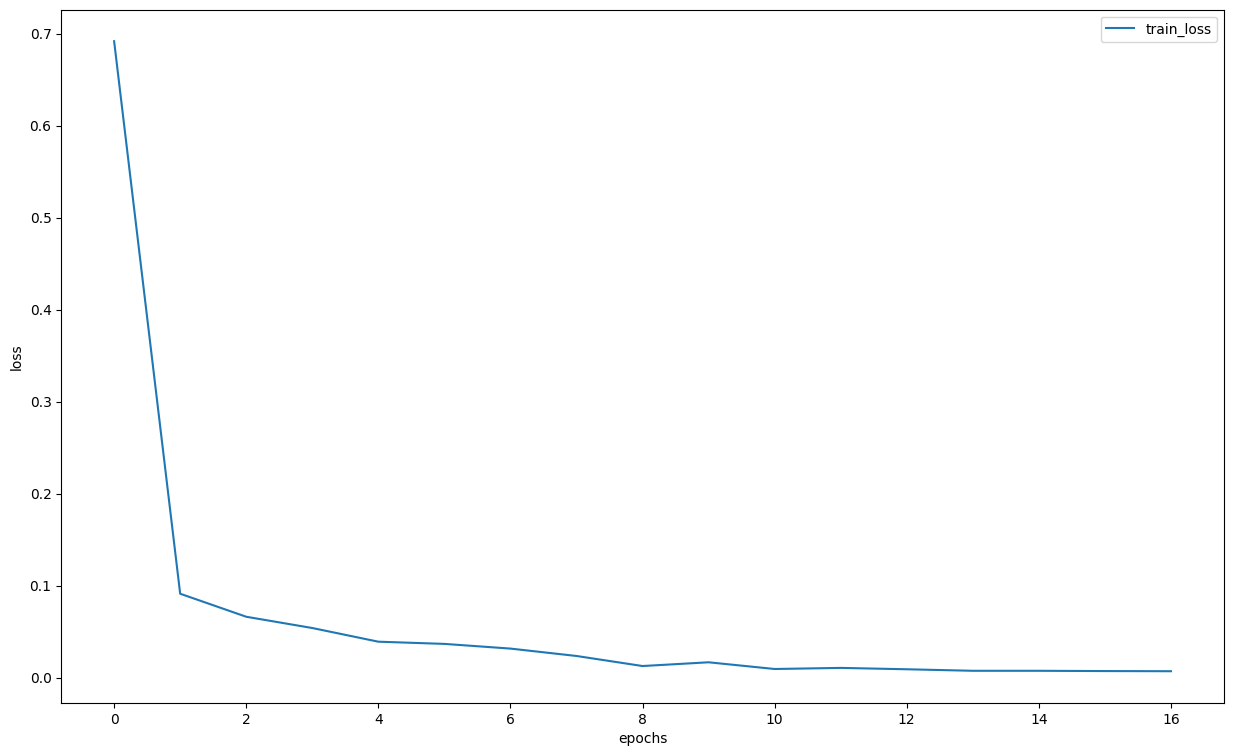

In [ ]:
draw_accuracy(history)

f1-score:

In [ ]:
print_f1_score(model_eff_all_data, val_dataset)

f1-score: 1.0


In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки."""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

Сделаем визуализацию того, насколько модель уверена в своих ответах.

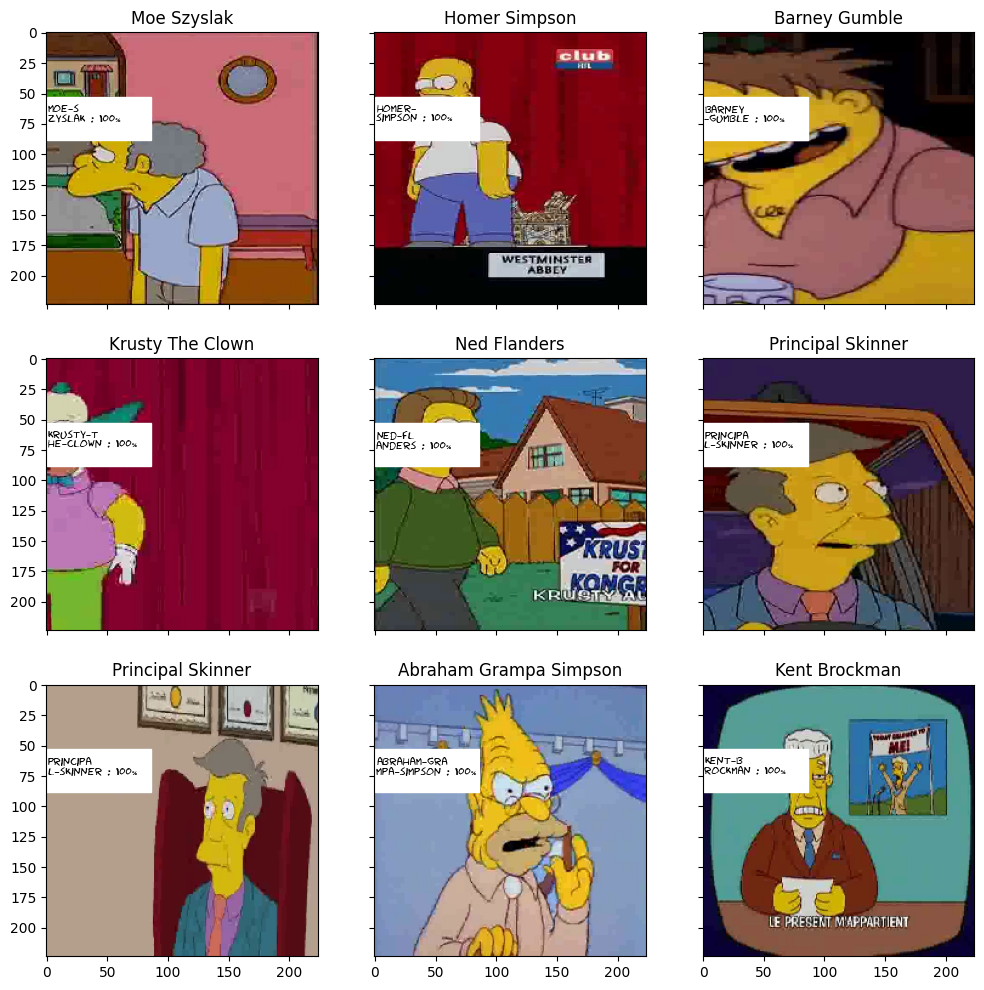

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12),\
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, len(val_dataset)))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0]\
                .split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_eff_all_data, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n'\
     + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label, predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left',\
               fontproperties=font, verticalalignment='top',fontsize=8,\
               color='black', fontweight='bold')

Сохраним получившуюся модель.

In [ ]:
torch.save(model_eff_all_data, 'simpsons_efficient.net_model_project.pth')